Import the required libraries:

In [62]:
import nltk
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [63]:
# Download NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [64]:
df=pd.read_csv("training_data_lowercase.csv", sep='\t', names=["labels", "text"], header=None)
print(df.columns)
print(df.head())

Index(['labels', 'text'], dtype='object')
   labels                                               text
0       0  donald trump sends out embarrassing new year‚s...
1       0  drunk bragging trump staffer started russian c...
2       0  sheriff david clarke becomes an internet joke ...
3       0  trump is so obsessed he even has obama‚s name ...
4       0  pope francis just called out donald trump duri...


In [65]:

data_train=df["text"]
data_test=df["labels"]

In [66]:
def tokenize_text(text):
    if isinstance(text, str):

        return word_tokenize(text)   # returns a list of tokens
    else:
        return []
data_token=data_train.apply(tokenize_text)
# filter_data=data_train.apply(tokenize_text)

Remove stop words

In [67]:
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words_clean = [word for word in text if word not in stop_words]
    return ' '.join(words_clean)

filter_data=data_token.apply(remove_stop_words)

print(filter_data.head())

0    donald trump sends embarrassing new year‚s eve...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obama‚s name coded website...
4    pope francis called donald trump christmas speech
Name: text, dtype: object


split the data for train and test

In [68]:
from sklearn.model_selection import train_test_split

# X=filter_data.to_frame(name='text')
# y=data_test.to_frame(name='labels')
X=filter_data
y=data_test
print(X)
print(y)
print(X.isna().sum())
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(X_train.shape)
print(X_test.shape)

0        donald trump sends embarrassing new year‚s eve...
1        drunk bragging trump staffer started russian c...
2        sheriff david clarke becomes internet joke thr...
3        trump obsessed even obama‚s name coded website...
4        pope francis called donald trump christmas speech
                               ...                        
34147         tears rain thais gather late king 's funeral
34148    pyongyang university needs non-u.s. teachers t...
34149    philippine president duterte visit japan ahead...
34150           japan 's abe may election many n't want pm
34151    demoralized divided : inside catalonia 's poli...
Name: text, Length: 34152, dtype: object
0        0
1        0
2        0
3        0
4        0
        ..
34147    1
34148    1
34149    1
34150    1
34151    1
Name: labels, Length: 34152, dtype: int64
0
(27321,)
(6831,)


Load the vectorizer and vectorize the data

In [69]:
print(X_train.shape)
X_train_str = [' '.join(tokens) if isinstance(tokens, list) else str(tokens) for tokens in X_train]
X_test_str  = [' '.join(tokens) if isinstance(tokens, list) else str(tokens) for tokens in X_test]


(27321,)


In [70]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-mpnet-base-v2')

In [71]:
X_train_embed = embedder.encode(X_train_str)
X_test_embed  = embedder.encode(X_test_str)

modal

In [72]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6
)
# from sklearn.linear_model import  LogisticRegression

# model = LogisticRegression(max_iter=500)

In [73]:
model.fit(X_train_embed, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

prediction

In [74]:
y_pred = model.predict(X_test_embed)

Accuracy

In [75]:
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9404186795491143
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3529
           1       0.94      0.94      0.94      3302

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



Confusion matrix

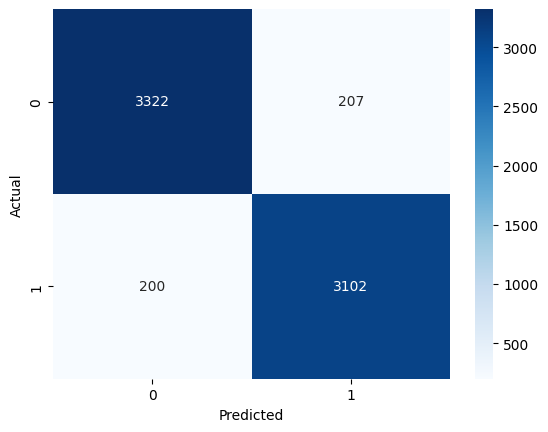

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()